In [11]:
import graphlab as gl
import numpy as np
import matplotlib.pyplot as plt 
import copy
from scipy.stats import multivariate_normal

%matplotlib inline

from distutils.version import StrictVersion

In [12]:
def log_sum_exp(Z):
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))

def loglikelihood(data, weights, means, covs):
    num_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0
    for d in data:
        
        Z = np.zeros(num_clusters)
        for k in range(num_clusters):
            
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        ll += log_sum_exp(Z)
        
    return ll

In [13]:
def compute_responsibilities(data, weights, means, covariances):
    num_data = len(data)
    num_clusters = len(means)
    resp = np.zeros((num_data, num_clusters))
    
    for i in range(num_data):
        for k in range(num_clusters):
            resp[i, k] = multivariate_normal.pdf(data[i], means[k], covariances[k])*weights[k]
    
    row_sums = resp.sum(axis=1)[:, np.newaxis]
    resp = resp / row_sums
    
    return resp

In [14]:
def compute_soft_counts(resp):
    counts = np.sum(resp, axis=0)
    return counts

In [15]:
def compute_weights(counts):
    num_clusters = len(counts)
    weights = [0.] * num_clusters
    
    for k in range(num_clusters):
        weights[k] = counts[k]/compute_soft_counts(counts)

    return weights

In [16]:
def compute_means(data, resp, counts):
    num_clusters = len(counts)
    num_data = len(data)
    means = [np.zeros(len(data[0]))] * num_clusters
    
    for k in range(num_clusters):
        weighted_sum = 0.
        for i in range(num_data):
            weighted_sum += data[i]*resp[i,k]
        means[k] = weighted_sum/counts[k]

    return means

In [17]:
def compute_covariances(data, resp, counts, means):
    num_clusters = len(counts)
    num_dim = len(data[0])
    num_data = len(data)
    covariances = [np.zeros((num_dim,num_dim))] * num_clusters
    
    for k in range(num_clusters):
        weighted_sum = np.zeros((num_dim, num_dim))
        for i in range(num_data):
            weighted_sum += resp[i,k] * (np.outer(data[i] - means[k], data[i] - means[k]))
        covariances[k] = weighted_sum/counts[k]

    return covariances

In [38]:
print data[0] 

[ 0.31845368  5.03182099]


In [18]:
def EM(data, init_means, init_covariances, init_weights, maxiter=1000, thresh=1e-4):
    
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]
    
    num_data = len(data)
    num_dim = len(data[0])
    num_clusters = len(means)
    
    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(data, weights, means, covariances)
    ll_trace = [ll]
    
    for it in range(maxiter):
        if it % 5 == 0:
            print("Iteration %s" % it)
        
        resp = compute_responsibilities(data, weights, means, covariances)

        counts = compute_soft_counts(resp)
        
        weights = compute_weights(counts)
        
        means = compute_means(data, resp, counts)
        
        covariances = compute_covariances(data, resp, counts, means)
        
        ll_latest = loglikelihood(data, weights, means, covariances)
        ll_trace.append(ll_latest)
        if (ll_latest - ll) < thresh and ll_latest > -np.inf:
            break
        ll = ll_latest
        
    
    if it % 5 != 0:
        print("Iteration %s" % it)
    
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}

    return out

In [19]:
def generate_MoG_data(num_data, means, covariances, weights):
    num_clusters = len(weights)
    data = []
    for i in range(num_data):
        k = np.random.choice(len(weights), 1, p=weights)[0]

        x = np.random.multivariate_normal(means[k], covariances[k])

        data.append(x)
    return data

In [20]:
init_means = [
    [5, 0],
    [1, 1], 
    [0, 5]  
]
init_covariances = [
    [[.5, 0.], [0, .5]], 
    [[.92, .38], [.38, .91]],
    [[.5, 0.], [0, .5]] 
]
init_weights = [1/4., 1/2., 1/4.]  

np.random.seed(4)
data = generate_MoG_data(100, init_means, init_covariances, init_weights)

In [ ]:
[ 0.00108914,0.01033349,0.05946514,0.20755375,0.43939129,0.56418958,0.43939129,0.20755375,0.05946514,0.01033349]

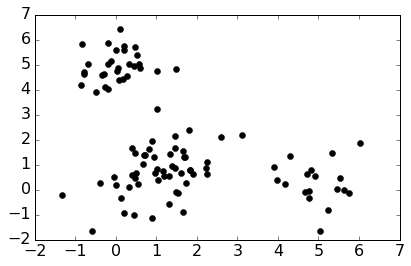

In [21]:
plt.figure()
d = np.vstack(data)
plt.plot(d[:,0], d[:,1],'ko')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [22]:
np.random.seed(4)

chosen = np.random.choice(len(data), 3, replace=False)
initial_means = [data[x] for x in chosen]
initial_covs = [np.cov(data, rowvar=0)] * 3
initial_weights = [1/3.] * 3

# Run EM 
results = EM(data, initial_means, initial_covs, initial_weights)

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


In [23]:
def generate_MoG_data(num_data, means, covariances, weights):
    num_clusters = len(weights)
    data = []
    for i in range(num_data):
        k = np.random.choice(len(weights), 1, p=weights)[0]

        x = np.random.multivariate_normal(means[k], covariances[k])

        data.append(x)
    return data

In [24]:
init_means = [
    [5, 0], 
    [1, 1], 
    [0, 5] 
]
init_covariances = [
    [[.5, 0.], [0, .5]],
    [[.92, .38], [.38, .91]], 
    [[.5, 0.], [0, .5]] 
]
init_weights = [1/4., 1/2., 1/4.] 

np.random.seed(4)
data = generate_MoG_data(100, init_means, init_covariances, init_weights)

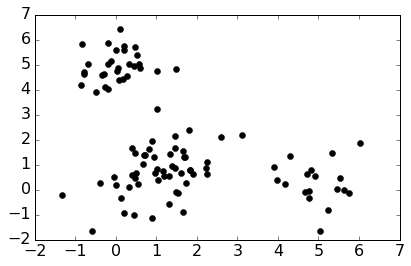

In [25]:
plt.figure()
d = np.vstack(data)
plt.plot(d[:,0], d[:,1],'ko')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [26]:
np.random.seed(4)

chosen = np.random.choice(len(data), 3, replace=False)
initial_means = [data[x] for x in chosen]
initial_covs = [np.cov(data, rowvar=0)] * 3
initial_weights = [1/3.] * 3

results = EM(data, initial_means, initial_covs, initial_weights)

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


In [27]:
import matplotlib.mlab as mlab
def plot_contours(data, means, covs, title):
    plt.figure()
    plt.plot([x[0] for x in data], [y[1] for y in data],'ko') # data

    delta = 0.025
    k = len(means)
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1]/(sigmax*sigmay)
        Z = mlab.bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i])
        plt.title(title)
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

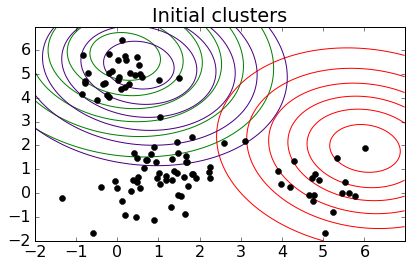

In [28]:
plot_contours(data, initial_means, initial_covs, 'Initial clusters')

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


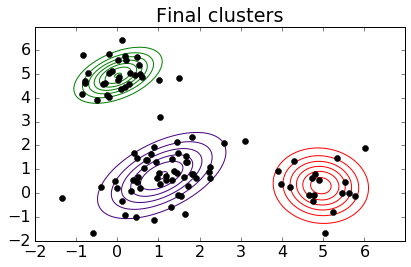

In [29]:
results = EM(data, initial_means, initial_covs, initial_weights)
plot_contours(data, results['means'], results['covs'], 'Final clusters')

Iteration 0
Iteration 5
Iteration 10
Iteration 11


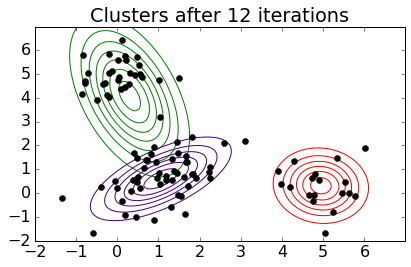

In [30]:
results = EM(data, initial_means, initial_covs, initial_weights, maxiter=12)
plot_contours(data, results['means'], results['covs'], 'Clusters after 12 iterations')

In [33]:
def EM_with_graph(data, init_means, init_covariances, init_weights, maxiter=1000, thresh=1e-4):
    
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]
    
    num_data = len(data)
    num_dim = len(data[0])
    num_clusters = len(means)
    
    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(data, weights, means, covariances)
    ll_trace = [ll]
    
    for it in range(maxiter):
        if it % 5 == 0:
            print("Iteration %s" % it)
        
        resp = compute_responsibilities(data, weights, means, covariances)

        counts = compute_soft_counts(resp)
        
        weights = compute_weights(counts)
        
        means = compute_means(data, resp, counts)
        
        covariances = compute_covariances(data, resp, counts, means)
        
        ll_latest = loglikelihood(data, weights, means, covariances)
        ll_trace.append(ll_latest)
        if (ll_latest - ll) < thresh and ll_latest > -np.inf:
            break
        ll = ll_latest
        
        plot_contours(data, means, covariances, '')
    
    if it % 5 != 0:
        print("Iteration %s" % it)
    
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}

    return out

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


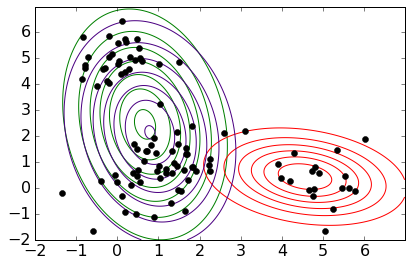

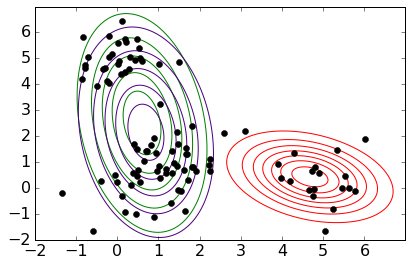

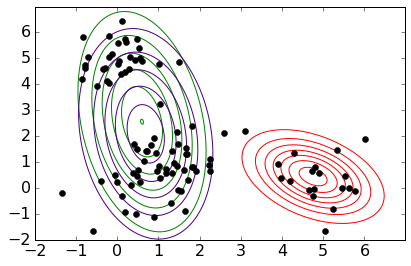

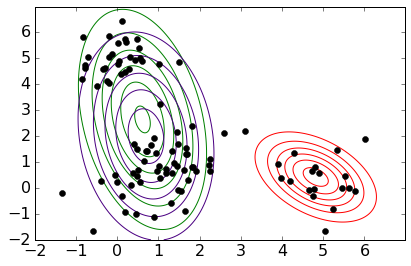

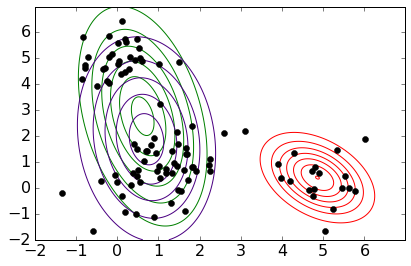

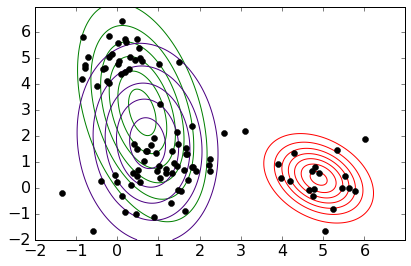

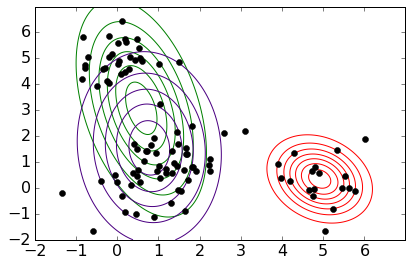

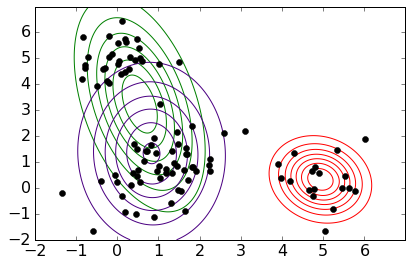

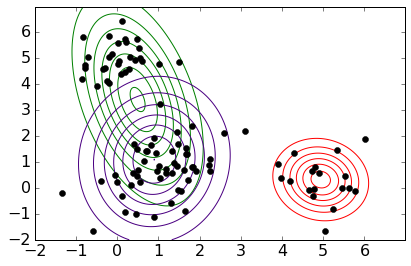

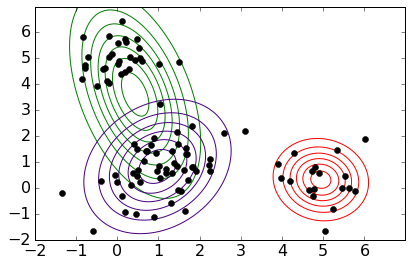

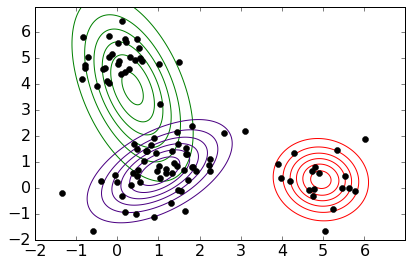

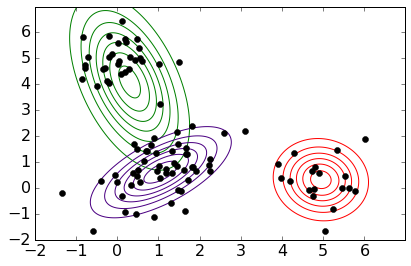

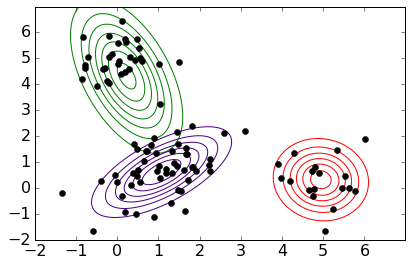

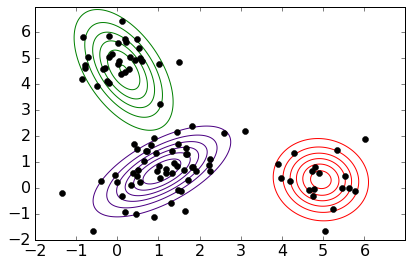

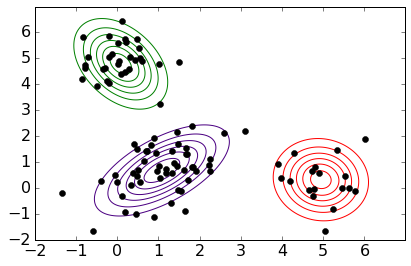

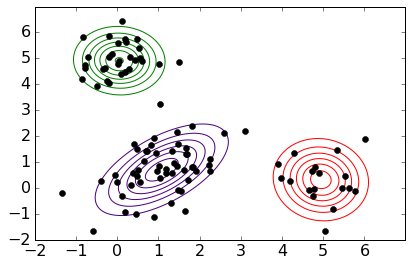

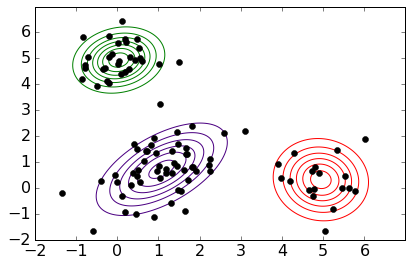

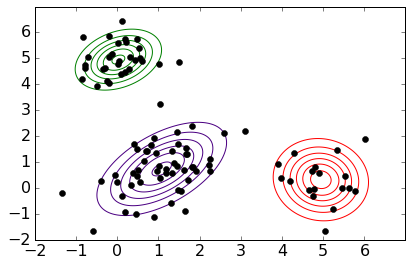

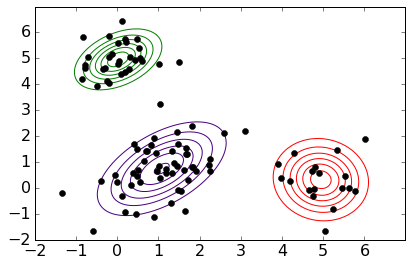

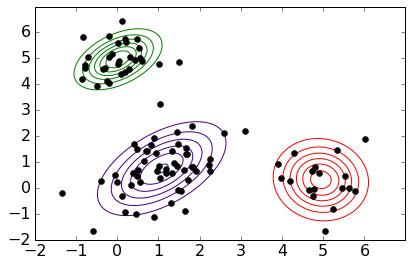

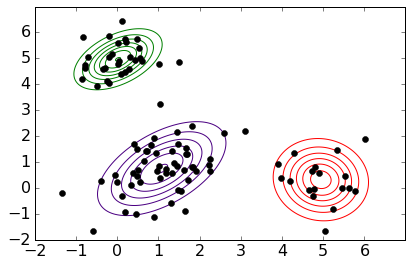

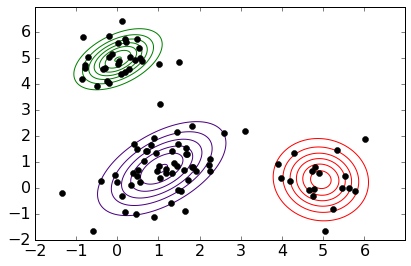

In [34]:
results = EM_with_graph(data, initial_means, initial_covs, initial_weights)